In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dsets

In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(image, image), cmap='gray')
    plt.title('y= ' + str(data_sample[1]))


In [3]:
image=16
composed= transforms.Compose([transforms.Resize((image, image)), transforms.ToTensor()])

In [4]:
train_dataset= dsets.MNIST( root='./data', train= True, download= True, transform= composed)
validation_dataset= dsets.MNIST( root='./data', train= False, download= True, transform= composed)

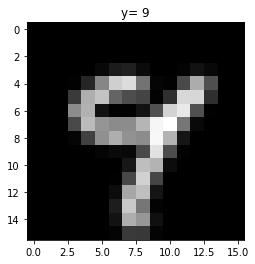

In [5]:
show_data(train_dataset[54])

In [6]:
class CNN(nn.Module):
    def __init__(self, out1=16, out2=32, number_of_classes=10):
        super(CNN, self).__init__()
        #1st convolution layer
        self.cnn1= nn.Conv2d(in_channels=1, out_channels= out1, kernel_size=5, padding=2)
        self.bn1= nn.BatchNorm2d(out1)
        self.maxpool1= nn.MaxPool2d(kernel_size=2)
        
        #2nd convolution layer
        self.cnn2= nn.Conv2d(in_channels=out1, out_channels= out2, kernel_size=5, stride=1, padding=2)
        self.bn2= nn.BatchNorm2d(out2)
        self.maxpool2= nn.MaxPool2d(kernel_size=2)
        
        #final layer
        self.linear= nn.Linear(out2*4*4, number_of_classes)
        self.bn3= nn.BatchNorm1d(number_of_classes)       
        
        
    def forward(self, x):
        #forward function for the 1st layer
        x= self.cnn1(x)
        x= self.bn1(x)
        x= torch.relu(x)
        x= self.maxpool1(x)
        
        #forward function for the second layer
        x= self.cnn2(x)
        x= self.bn2(x)
        x= torch.relu(x)
        x= self.maxpool2(x)
         
        # forward function for the final layer
        x= x.view(x.size(0), -1)
        x= self.linear(x)
        x= self.bn3(x)
        
        return x
        
    
        
        
        

In [7]:
model= CNN( out1=16, out2=32, number_of_classes=10)

In [8]:
train_loader= DataLoader(dataset= train_dataset, batch_size=100)
validation_loader= DataLoader( dataset= validation_dataset, batch_size=100)

In [9]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.SGD( model.parameters(), lr=0.1)

In [10]:
epochs=10
useful_data={'training_loss':[],  'validation_accuracy':[]}
for epochs in range(epochs):
    cost=0
    model.train()
    for x,y in train_loader:        
        optimizer.zero_grad()
        z= model(x)
        loss= criterion(z,y)        
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    useful_data['training_loss'].append(cost)
    
    correct=0
    model.eval()
    for x_test, y_test in validation_loader:        
        yhat= model(x_test)
        _,label= torch.max(yhat.data, 1)
        correct+= (label == y_test).sum().item()
    accuracy= 100*(correct/len(validation_dataset))
    useful_data['validation_accuracy'].append(accuracy)
    

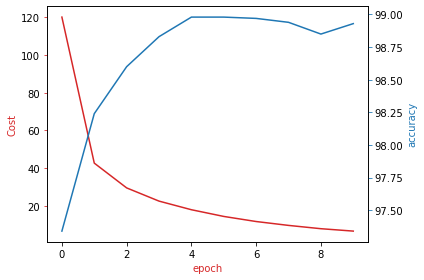

In [11]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(useful_data['training_loss'], color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( useful_data['validation_accuracy'], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [12]:
path='./mydata.pth'
torch.save(model.state_dict(), path) 

In [11]:
model= CNN(out1=16, out2=32, number_of_classes=10)
model.load_state_dict(torch.load('./mydata.pth'))
model.eval()

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [12]:
correct=0
for x_test, y_test in validation_loader:
    z= model(x_test)
    _,label= torch.max(z.data, 1)
    correct+= (label == y_test).sum().item()
accuracy= correct/ len(validation_dataset)
print(accuracy)

0.9893


In [19]:
from tkinter import *
import tkinter as tk
import win32gui
from PIL import ImageGrab, Image
import numpy as np
def predict_digit(img):
    #resize image to 28x28 pixels
    composed= transforms.Compose([transforms.Resize((image, image)), transforms.ToTensor()])
    #reshaping to support our model input and normalizing
    img= composed(img)
    #predicting the class
    img= img.unsqueeze(1)
    res= model(img)
    _,label= torch.max(res.data, 1)
    r= label.tolist()
    return max(r)
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        # Creating elements
        self.canvas = tk.Canvas(self, width=300, height=300, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        #self.canvas.bind("<Motion>", self.start_pos)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    def clear_all(self):
        self.canvas.delete("all")
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit  = predict_digit(im)
        self.label.configure(text= str(digit))
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=8
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')
app = App()
mainloop()
